## Part 2: Continuous regression

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')

OUTPUT_DIR = Path("../outputs")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True, parents=True) # Ensure this exists for saving

RANDOM_STATE = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
N_EPOCHS = 20

print("Loading preprocessed sequence data from dl_sequences.npz...")

try:
    data = np.load(OUTPUT_DIR / 'dl_sequences.npz')
    
    # Load sequences
    X_train_seq = data['X_train_seq']
    X_val_seq = data['X_val_seq']
    X_test_seq = data['X_test_seq']
    
    X_train_static = data['X_train_static']
    X_val_static = data['X_val_static']
    X_test_static = data['X_test_static']
    
    # Load continuous targets (Crucial change from classification)
    y_train = data['y_train_cont']
    y_val = data['y_val_cont']
    y_test = data['y_test_cont']
    
    mask_train = data['mask_train']
    mask_val = data['mask_val']
    mask_test = data['mask_test']
    
    N_TEMPORAL_FEATURES = X_train_seq.shape[-1]
    N_STATIC_FEATURES = X_train_static.shape[-1]
    SEQUENCE_LENGTH = X_train_seq.shape[1]
    
except FileNotFoundError:
    print(f"Error: dl_sequences.npz not found in {OUTPUT_DIR}. Rerun the preprocessing script.")
    raise

print(f"Data loaded for Transformer Regression:")
print(f"  Temporal features (Raw D): {N_TEMPORAL_FEATURES}")
print(f"  Static features: {N_STATIC_FEATURES}")
print(f"  Train samples: {len(X_train_seq)}")

Loading preprocessed sequence data from dl_sequences.npz...
Data loaded for Transformer Regression:
  Temporal features (Raw D): 34
  Static features: 5
  Train samples: 6963


In [18]:
class ICUDataset(Dataset):
    """Custom Dataset for loading sequence and static features with masks."""
    def __init__(self, sequences, static, labels, masks):
        self.sequences = torch.FloatTensor(sequences)
        self.static = torch.FloatTensor(static)
        self.labels = torch.FloatTensor(labels)
        self.masks = torch.BoolTensor(masks)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'static': self.static[idx],
            'label': self.labels[idx],
            'mask': self.masks[idx]
        }

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape is (Seq_len, Batch, D_MODEL)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class ICUTransformerRegressor(nn.Module):
    def __init__(self, 
                 n_temporal_features: int, 
                 d_model: int, 
                 n_static: int,
                 n_heads: int = 8, 
                 n_layers: int = 3, 
                 dropout: float = 0.1, 
                 dim_feedforward: int = 2048):
        super().__init__()
        
        self.d_model = d_model
        
        # TEMPORAL FEATURE PROJECTION (Handles case where N_TEMPORAL_FEATURES is not divisible by N_HEADS)
        self.feature_projector = nn.Linear(n_temporal_features, d_model)
        
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=False # Expects (Seq_len, Batch, Features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
      
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )
        self.regressor = nn.Sequential( 
            nn.Linear(d_model * 2, d_model), # * 2 because of concatenation
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1) # Single linear output for regression
        )
    def forward(self, src: torch.Tensor, static: torch.Tensor, src_mask: torch.Tensor = None):
        
        src = self.feature_projector(src) 
        src = src.permute(1, 0, 2)
        src = self.pos_encoder(src) 
        output_temporal = self.transformer_encoder(src, src_key_padding_mask=src_mask) 
        
        temporal_representation = output_temporal[-1, :, :] 
        static_representation = self.static_mlp(static) 
        
        combined_representation = torch.cat(
            [temporal_representation, static_representation], 
            dim=1
        )
        
        output = self.regressor(combined_representation).squeeze(-1) 
        
        return output




In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_HEADS = 8  
N_LAYERS = 3
DROPOUT = 0.1


if N_TEMPORAL_FEATURES % N_HEADS != 0:
    D_MODEL = 32 
else:
    D_MODEL = N_TEMPORAL_FEATURES

model = ICUTransformerRegressor(
    n_temporal_features=N_TEMPORAL_FEATURES,
    d_model=D_MODEL,
    n_static=N_STATIC_FEATURES,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
N_EPOCHS = 100

In [27]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nModel initialized for Continuous LOS Regression (D_MODEL={D_MODEL}).")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Model initialized for Continuous LOS Regression (D_MODEL=32).
Model Parameters: 416,385


In [28]:
train_dataset = ICUDataset(X_train_seq, X_train_static, y_train, mask_train)
val_dataset = ICUDataset(X_val_seq, X_val_static, y_val, mask_val)
test_dataset = ICUDataset(X_test_seq, X_test_static, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in loader:
        sequence = batch['sequence'].to(device)
        static = batch['static'].to(device)
        # Labels must be float for MSELoss
        labels = batch['label'].to(device).float() 
        mask = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(sequence, static, src_mask=mask) 
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * sequence.size(0)
        
    return total_loss / len(loader.dataset)

In [30]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in loader:
            sequence = batch['sequence'].to(device)
            static = batch['static'].to(device)
            labels = batch['label'].to(device).float()
            mask = batch['mask'].to(device)

            outputs = model(sequence, static, src_mask=mask) 
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequence.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Calculate Regression Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return avg_loss, mae, rmse, r2

In [31]:
print("\n" + "=" * 60)
print("STARTING MODEL TRAINING (REGRESSION)")
print("=" * 60)

# History lists
train_loss_history = []
train_mae_history = [] 
train_rmse_history = [] 
train_r2_history = []
val_loss_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

best_val_loss = float('inf')
early_stop_patience = 5
patience_counter = 0

for epoch in range(N_EPOCHS):
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    _, train_mae, train_rmse, train_r2 = evaluate_model(model, train_loader, criterion, DEVICE)
    val_loss, val_mae, val_rmse, val_r2 = evaluate_model(model, val_loader, criterion, DEVICE) 
    
   
    train_loss_history.append(train_loss)
    train_mae_history.append(train_mae) 
    train_rmse_history.append(train_rmse) 
    train_r2_history.append(train_r2)
    val_loss_history.append(val_loss)
    val_mae_history.append(val_mae)
    val_rmse_history.append(val_rmse)
    val_r2_history.append(val_r2)
    print(f"Epoch {epoch+1:02d}/{N_EPOCHS}: | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Train MAE: {train_mae:.3f} | "
          f"Val MAE: {val_mae:.3f} | "
          f"Train RMSE: {train_rmse:.3f} | "
          f"Val RMSE: {val_rmse:.3f} | "
          f"Train R2: {train_r2:.4f}|"
          f"Val R2: {val_r2:.4f}")
    
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save(model.state_dict(), MODEL_DIR / 'best_transformer_regressor.pt')
        print(f"  -> Model saved. New best Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement.")
        break

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)


STARTING MODEL TRAINING (REGRESSION)
Epoch 01/100: | Train Loss: 25.3024 | Val Loss: 35.6340 | Train MAE: 2.327 | Val MAE: 2.633 | Train RMSE: 4.844 | Val RMSE: 5.969 | Train R2: -0.2642|Val R2: -0.2170
  -> Model saved. New best Val Loss: 35.6340
Epoch 02/100: | Train Loss: 22.7536 | Val Loss: 33.7307 | Train MAE: 2.156 | Val MAE: 2.466 | Train RMSE: 4.668 | Val RMSE: 5.808 | Train R2: -0.1743|Val R2: -0.1520
  -> Model saved. New best Val Loss: 33.7307
Epoch 03/100: | Train Loss: 21.2516 | Val Loss: 32.1268 | Train MAE: 2.095 | Val MAE: 2.407 | Train RMSE: 4.520 | Val RMSE: 5.668 | Train R2: -0.1007|Val R2: -0.0973
  -> Model saved. New best Val Loss: 32.1268
Epoch 04/100: | Train Loss: 20.0266 | Val Loss: 30.8288 | Train MAE: 2.121 | Val MAE: 2.430 | Train RMSE: 4.401 | Val RMSE: 5.552 | Train R2: -0.0437|Val R2: -0.0529
  -> Model saved. New best Val Loss: 30.8288
Epoch 05/100: | Train Loss: 19.1855 | Val Loss: 29.9316 | Train MAE: 2.205 | Val MAE: 2.511 | Train RMSE: 4.324 | Val 

In [32]:
try:
    model.load_state_dict(torch.load(MODEL_DIR / 'best_transformer_regressor.pt'))
except FileNotFoundError:
    print("Could not load best model. Using current model state for test evaluation.")

# Run final evaluation
test_loss, test_mae, test_rmse, test_r2 = evaluate_model(model, test_loader, criterion, DEVICE)

print(f"\nFinal Test Set Results:")
print(f"  Test Loss (MSE): {test_loss:.4f}")
print(f"  Test MAE: {test_mae:.3f} days")
print(f"  Test RMSE: {test_rmse:.3f} days")
print(f"  Test R2: {test_r2:.4f}")


Final Test Set Results:
  Test Loss (MSE): 14.1436
  Test MAE: 1.946 days
  Test RMSE: 3.761 days
  Test R2: 0.2813


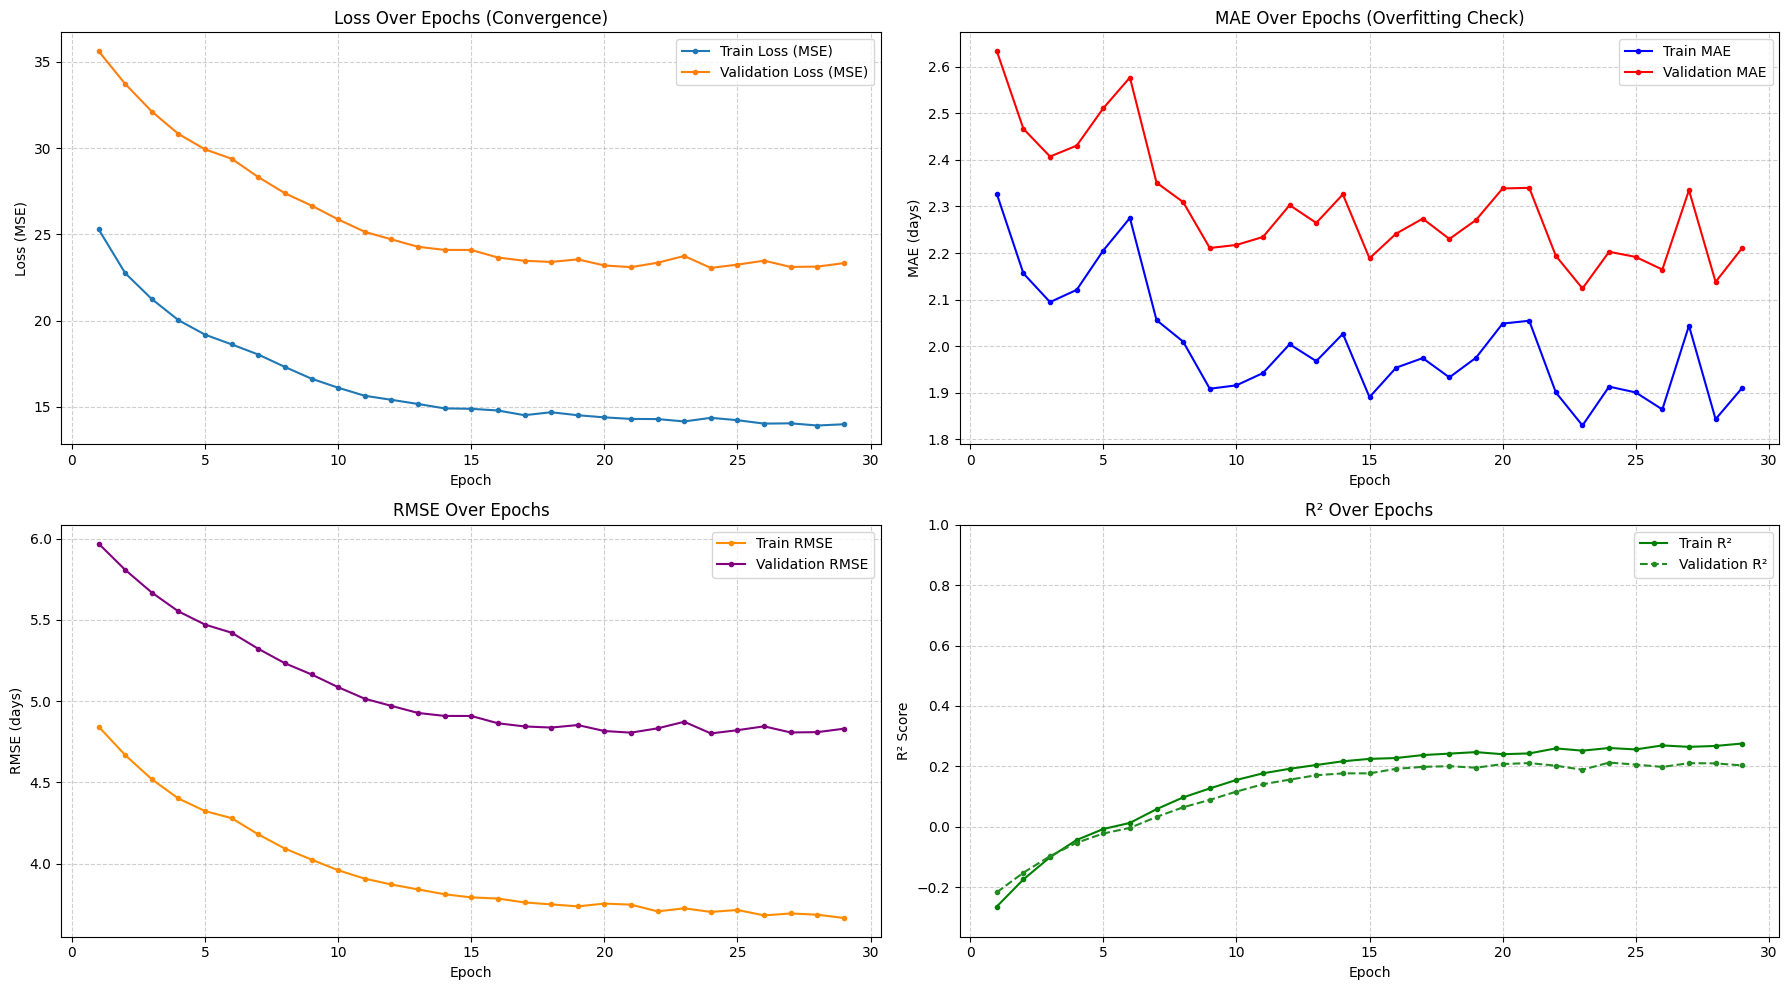

Saved plot: ../outputs/transformer_regression_history_full.png


In [33]:
epochs_run = len(val_loss_history)
epochs = range(1, epochs_run + 1)

plt.figure(figsize=(18, 10)) 


plt.subplot(2, 2, 1) 
plt.plot(epochs, train_loss_history, label='Train Loss (MSE)', marker='.')
plt.plot(epochs, val_loss_history, label='Validation Loss (MSE)', marker='.')
plt.title('Loss Over Epochs (Convergence)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.subplot(2, 2, 2)
plt.plot(epochs, train_mae_history, label='Train MAE', color='blue', marker='.') 
plt.plot(epochs, val_mae_history, label='Validation MAE', color='red', marker='.')
plt.title('MAE Over Epochs (Overfitting Check)')
plt.xlabel('Epoch')
plt.ylabel('MAE (days)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_rmse_history, label='Train RMSE', color='darkorange', marker='.') 
plt.plot(epochs, val_rmse_history, label='Validation RMSE', color='purple', marker='.')
plt.title('RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE (days)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 2, 4)
plt.plot(epochs, train_r2_history, label='Train R²', color='green', marker='.') 
plt.plot(epochs, val_r2_history, label='Validation R²', color='forestgreen', linestyle='--', marker='.')
plt.title('R² Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.ylim(min(0, np.nanmin(train_r2_history + val_r2_history) - 0.1), 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'transformer_regression_history_full.png', dpi=150)
plt.show()
print(f"Saved plot: {OUTPUT_DIR / 'transformer_regression_history_full.png'}")